In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dict = {
    "(1)": [1, 1, 1, 1, 1, 1, 1, 1],
    "a": [-1, 1, -1, -1, 1, 1, -1, 1],
    "b": [-1, -1, 1, -1, 1, -1, 1, 1],
    "c": [-1, -1, -1, 1, -1, 1, 1, 1],
    "ab": [1, -1, -1, 1, 1, -1, -1, 1],
    "ac": [1, -1, 1, -1, -1, 1, -1, 1],
    "bc": [1, 1, -1, -1, -1, -1, 1, 1],
    "abc": [-1, 1, 1, 1, -1, -1, -1, 1],
}

# This is going to be used for the signs of each term during SS computation
df_enc = pd.DataFrame(data_dict)
df_enc

,(1),a,b,c,ab,ac,bc,abc
0,1,-1,-1,-1,1,1,1,-1
1,1,1,-1,-1,-1,-1,1,1
2,1,-1,1,-1,-1,1,-1,1
3,1,-1,-1,1,1,-1,-1,1
4,1,1,1,-1,1,-1,-1,-1
5,1,1,-1,1,-1,1,-1,-1
6,1,-1,1,1,-1,-1,1,-1
7,1,1,1,1,1,1,1,1


In [3]:
#data collected from experiment
data_trial = pd.DataFrame({
    "BLOCK 1": [58, 79, 44, 56, 53, 47, 45, 60],
    "BLOCK 2": [52, 72, 55, 41, 56, 82, 52, 71],
    "BLOCK 3": [62, 83, 60, 72, 67, 92, 65, 73]
},index=['(1)','a','b','c','ab','ac','bc','abc'])
data_trial

,BLOCK 1,BLOCK 2,BLOCK 3
(1),58,52,62
a,79,72,83
b,44,55,60
c,56,41,72
ab,53,56,67
ac,47,82,92
bc,45,52,65
abc,60,71,73


In [4]:
data_trial.describe()

,BLOCK 1,BLOCK 2,BLOCK 3
count,8.000000,8.000000,8.00000
mean,55.250000,60.125000,71.75000
std,11.335784,13.516524,10.95119
min,44.000000,41.000000,60.00000
25%,46.500000,52.000000,64.25000
50%,54.500000,55.500000,69.50000
75%,58.500000,71.250000,75.50000
max,79.000000,82.000000,92.00000


In [8]:
x =compute_SS(data_trial,df_enc,option='Block')
x

,Sum Squares,Degrees of Freedom,Mean Square,F_0
Blocks,1149.750000,2.0,574.875,7.270873
a,1247.041667,1.0,1247.041667,15.772265
b,376.041667,1.0,376.041667,4.756079
c,9.375000,1.0,9.375,0.118573
ab,126.041667,1.0,126.041667,1.594143
ac,9.375000,1.0,9.375,0.118573
bc,92.041667,1.0,92.041667,1.16412
abc,51.041667,1.0,51.041667,0.645562
Total,4167.625000,23.0,,
Error,1106.916667,14.0,79.065476,


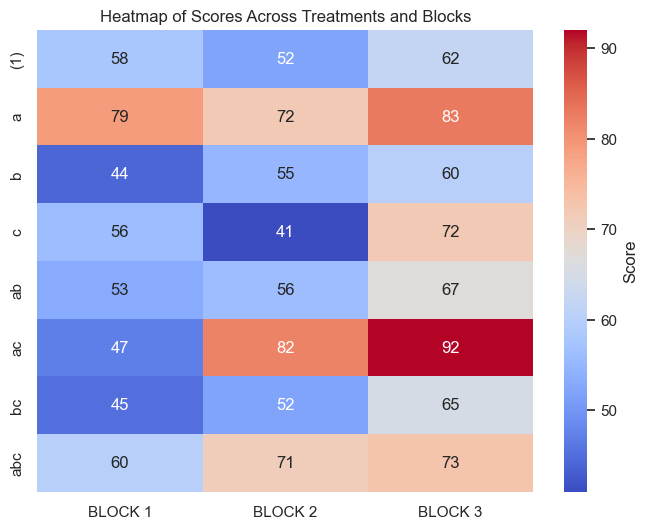

In [9]:
# need to melt data for easier plotting
df_melted = data_trial.reset_index().melt(id_vars="index", var_name="Block", value_name="Score")
df_melted.rename(columns={"index": "Treatment"}, inplace=True)

sns.set(style="whitegrid")

# for heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data_trial, annot=True, cmap="coolwarm", fmt="d", cbar_kws={'label': 'Score'})
plt.title("Heatmap of Scores Across Treatments and Blocks")
plt.show()

In [6]:
def compute_SS(df,encoding,option=''):
    SS = {}
    dof = {}
    MS = {}
    F_0 = {}
    treatment_mask = ~df.index.isin(['(1)','Blocks', 'Total', 'Error', 'Model'])
    storage = []
    dof_count=0
    n_rep = df.sum(axis=0).size
    n_rows = df.sum(axis=1).size
    n_factors = (np.log(n_rows)/np.log(2))
    effect_sums = df.sum(axis=1).values.flatten()
    total = df.sum().sum()
    CF = (total**2)/(n_rep*n_rows)
    dof['Total'] = n_rep*n_rows - 1
    
    if option == 'Block':
        block_sums = df.sum(axis=0).values
        SS['Blocks'] = (np.sum(block_sums**2)/n_rows) - CF
        dof['Blocks'] = n_rep - 1
    
    for i in list(df.index):        
        encoding_key = encoding.loc[:,[i]].values.flatten()
        if i == '(1)':
            pass
        else:
            SS[i] = np.dot(effect_sums,encoding_key)
            SS[i] = (SS[i]**2) / ( n_rep * ( 2**(n_factors) ) )
            dof[i] = 1
            dof_count +=1
            storage.append(SS[i])
            
    SS['Total'] = np.sum( (df.values - df.values.mean())**2) 
    SS_df = pd.DataFrame(SS,index=[0])
    
    model_sum = sum(val for key, val in SS.items() if key not in ['Total'])
    
    SS['Error'] = SS['Total'] - model_sum
    SS_df = pd.DataFrame(SS,index=['Sum Squares']).T
    
    if option == 'Block':
        dof['Error'] = dof['Total'] - dof['Blocks'] - dof_count
        
    else: 
        dof['Error'] = dof['Total'] - dof_count    
    
    for j in SS.keys():
        if j != 'Total':
            MS[j] = SS[j]/dof[j]
        elif j == 'Total':
            MS[j] = ''
            continue
           
    for k in SS.keys():
        if k != 'Error' and k!= 'Total':
            F_0[k] = MS[k]/MS['Error']
        else:
            F_0[k] = ''
            continue
            
    MS_df = pd.DataFrame(MS,index=['Mean Square']).T
    F_0_df = pd.DataFrame(F_0,index=['F_0']).T
    dof = pd.DataFrame(dof,index=['Degrees of Freedom']).T
    SS_df = pd.merge(SS_df,dof, left_index=True, right_index=True)
    SS_df = pd.merge(SS_df,MS_df, left_index=True, right_index=True)
    SS_df = pd.merge(SS_df,F_0_df, left_index=True, right_index=True)
   # SS_df.loc[['Total', 'Error']] = SS_df.loc[['Error', 'Total']].values
    model = {'Sum Squares':model_sum,'Degrees of Freedom':n_rows-1,
             'Mean Square':model_sum/(n_rows-1),
             'F_0':(model_sum/(n_rows-1))/MS['Error']}
    
    SS_df.loc['Model'] = model.values()
    return SS_df

In [7]:
def anova_adjust(df, drop_trt=[]):
    df = df.copy()
    # Drop the specified treatments if they exist
    for trt in drop_trt:
        if trt in df.index:
            df = df.drop(index=trt, errors='ignore')
    
    # Sum all SS rows not in ['Blocks', 'Total', 'Error', 'Model']
    mask = ~df.index.isin(['Blocks', 'Total', 'Error', 'Model'])
    model_ss_new = df.loc[mask, 'Sum Squares'].sum()
    df.at['Model', 'Sum Squares'] = model_ss_new

    total_ss = df.at['Total', 'Sum Squares']
    error_ss = total_ss - model_ss_new
    df.at['Error', 'Sum Squares'] = error_ss

    n_dropped = len(drop_trt)
    df.at['Model', 'Degrees of Freedom'] = df.at['Model', 'Degrees of Freedom'] - n_dropped
    df.at['Error', 'Degrees of Freedom'] = df.at['Error', 'Degrees of Freedom'] + n_dropped

    df.at['Model', 'Mean Square'] = df.at['Model', 'Sum Squares'] / df.at['Model', 'Degrees of Freedom']
    df.at['Error', 'Mean Square'] = df.at['Error', 'Sum Squares'] / df.at['Error', 'Degrees of Freedom']

    error_ms = df.at['Error', 'Mean Square']

    for idx in df.index:
        if idx not in ['Total', 'Error']:
            # Recompute Mean Square for this factor
            df.at[idx, 'Mean Square'] = df.at[idx, 'Sum Squares'] / df.at[idx, 'Degrees of Freedom']
            # Compute F value if not Total or Error
            df.at[idx, 'F_0'] = df.at[idx, 'Mean Square'] / error_ms

    df.at['Total', 'Mean Square'] = np.nan
    df.at['Total', 'F_0'] = np.nan


    df.at['Error', 'F_0'] = np.nan

    return df
